In [1]:
import time
start_time=time.time()

In [59]:
#import sys
#from pathlib import Path
import json
import numpy as np
#import strucfunc
import matplotlib.pyplot as plt
import time
#from astropy.io import fits
import pandas as pd
import seaborn as sns
#import math
#import sys
#import os
#from sabreMod import sosf,sosfh
#from scipy import interpolate
#import itertools
import lmfit

In [60]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

In [80]:
def seeing(r, s0):
    return (np.tanh((r / (2.0 * s0))**2))**2

In [81]:
def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m)

Add a new version of the function with added white noise parameter:

In [96]:
def bfunc02(r, r0, sig2, m, s0, noise):
    "Structure function with added seeing (scale `s0`) and noise"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m) + noise

In [84]:
data = json.load(open("SFdata//604.json"))

pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
#s0 = 0.5            # parsec
s0 = 4.09/2.355                    # parsec
m = 1.6

54.62045699825188

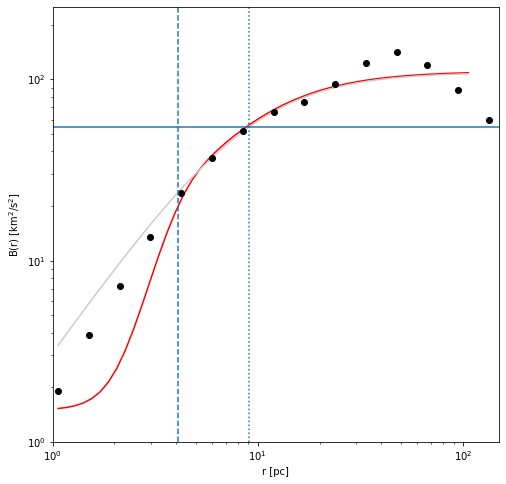

In [97]:
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]

rgrid = pixscale * np.logspace(0.0, 2)
r0 = np.interp(sig2, B, r)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline(2.355 * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")


ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 250],
    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2

Example plot of the new function.  Obviously this is not a good fit.  The effects of the seeing and noise can be clearly seen. 

In [98]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [99]:
relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
weights[-5:] /= 4.0

This time I will freezer the sig2 parameter at its nominal value by setting the `vary` property to `False`. 

The reason for doing this is that I want to concentrate on the small scales, where the seeing and noise are important.  The value of `sig2` is irrelvant to the small scales.

In [100]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
model02.set_param_hint("sig2", value=sig2, vary=False)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2    54.6205        0      inf    False    


In [101]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0,
)

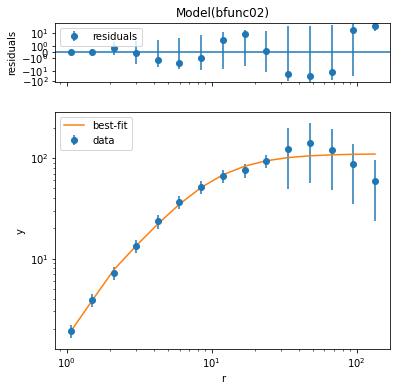

In [102]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);



In [103]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 15
    # variables        = 4
    chi-square         = 3.59013342
    reduced chi-square = 0.32637577
    Akaike info crit   = -13.4479125
    Bayesian info crit = -10.6157117
[[Variables]]
    r0:     9.32684909 +/- 0.46111073 (4.94%) (init = 9.091583)
    sig2:   54.62046 (fixed)
    m:      1.84105096 +/- 0.09473082 (5.15%) (init = 1.6)
    s0:     0.68421710 +/- 0.10053248 (14.69%) (init = 1.73673)
    noise:  1.31113488 +/- 0.34414569 (26.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise) =  0.819
    C(r0, m)     = -0.795
    C(m, s0)     = -0.425
    C(r0, s0)    =  0.349
    C(r0, noise) =  0.206


In [94]:
result2.conf_interval()
print(result2.ci_report())

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0:  -1.19163  -0.75104  -0.36935   8.96798  +0.40616  +0.92130  +1.68650
 m :  -0.23247  -0.13775  -0.06455   1.82008  +0.06501  +0.13983  +0.22825
 s0:      -inf      -inf  -0.06950   0.41507  +0.04369  +0.08646  +0.13961


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/lmfit/confidence.py:334: UserWarning: rel_change=4.4832164372442886e-07 < 1e-05 at iteration 6 and prob(s0=0.1341011579444719) = 0.8052089656662794 < max(sigmas).
  warn(errmsg)


The best-fit model has a higher seeing than in the other notebook. This is compensated for by the noise at the smallest scales. 

In [110]:
plt.style.use([
    "seaborn-poster",
])

In [111]:
plot_limits = {
    "s0": [0.0, 2.0],
    "m": [1.0, 2.5],
    "r0": [5.0, 15.0],
    "noise": [0.0, 3.0],
}

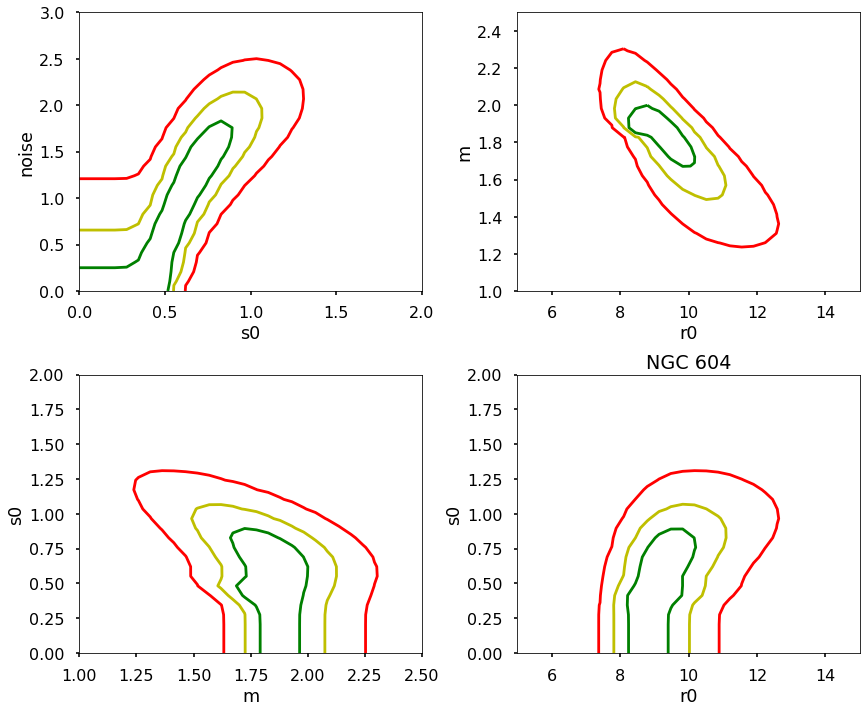

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('NGC 604')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

This shows that we can have a seeing as high as roughly 1, so long as we also incerase the noise.  Therefore, we will try again, but setting a minimum value of 1.0 for `s0`. 

In [123]:
model02.set_param_hint("s0", min=1.0)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        1      inf     True    
sig2    54.6205        0      inf    False    


In [124]:
result3 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0,
)

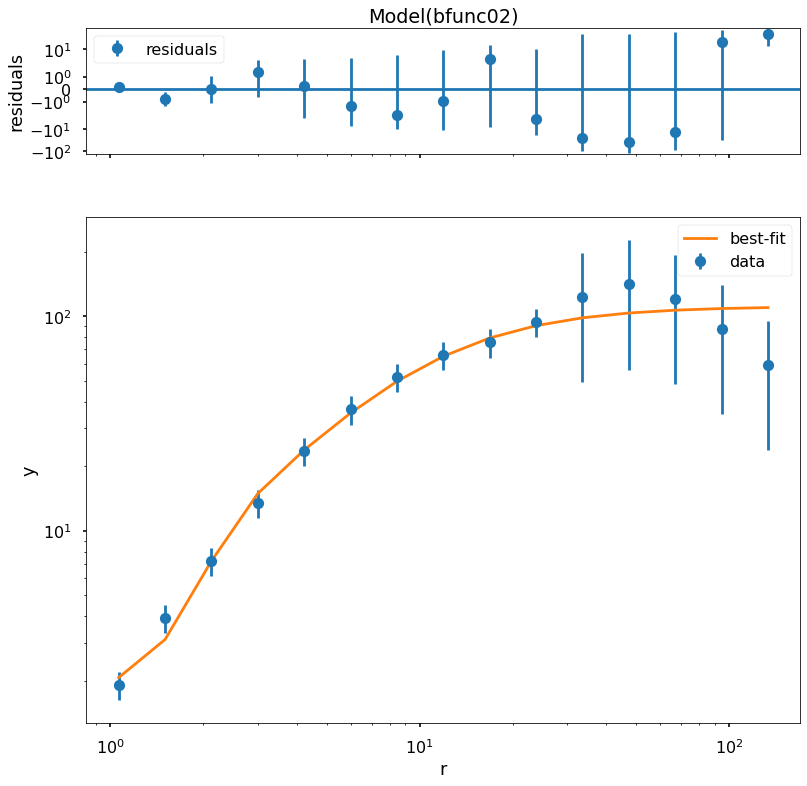

In [125]:
fig, _ = result3.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);

This model is a bit worse than the previous one, but it can't be ruled out

In [127]:
print(result3.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 15
    # variables        = 4
    chi-square         = 5.47661726
    reduced chi-square = 0.49787430
    Akaike info crit   = -7.11343869
    Bayesian info crit = -4.28123789
##  Warning: uncertainties could not be estimated:
    s0:     at boundary
[[Variables]]
    r0:     9.84165903 (init = 9.091583)
    sig2:   54.62046 (fixed)
    m:      1.63756555 (init = 1.6)
    s0:     1.00000000 (init = 1.73673)
    noise:  1.85715299 (init = 1)


In [135]:
for p in result3.model.param_names:
    result3.params[p].stderr = result3.params[p].value * 0.1

In [136]:
result3.conf_interval()
print(result3.ci_report())

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/lmfit/confidence.py:319: UserWarning: Bound reached with prob(s0=1.0) = 0.0 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -1.96123  -1.26580  -0.63770   9.84166  +0.74866  +1.79429  +3.61306
 m    :  -0.40422  -0.24414  -0.11645   1.63757  +0.12276  +0.27357  +0.49163
 s0   :      -inf      -inf      -inf   1.00000  +0.04247  +0.17087  +0.42837
 noise:  -0.78813  -0.45902  -0.21238   1.85715  +0.21098  +0.45257  +0.76926


In [137]:
plot_limits = {
    "s0": [1.0, 2.0],
    "m": [1.0, 2.5],
    "r0": [5.0, 15.0],
    "noise": [0.0, 3.0],
}

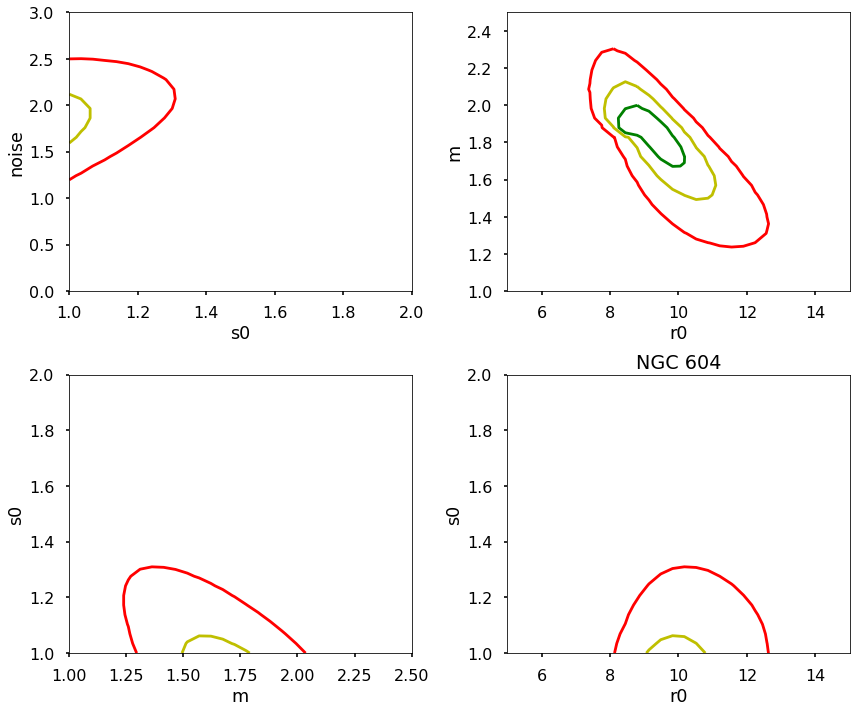

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('NGC 604')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

So the best-fit value of $m$ is reduced slightly to $1.64 \pm 0.1$ and r0 incerases very slighty. |

In [16]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 44.007484912872314 seconds ---
